<a href="https://colab.research.google.com/github/ChelseaLiu0822/LDRPM-Loan-Default-Risk-Prediction-Model/blob/main/LDRPM_Loan_Default_Risk_Prediction_Model_Project_FinalVersion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LDRPM_Loan_Default_Risk_Prediction

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from sklearn.ensemble import IsolationForest

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'home-credit-credit-risk-model-stability:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F50160%2F7921029%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T205423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D98a3018592b601346690c7ac0e758565053dc5fdd46fe9e7f00d96db257e8fcbb01442fe0c8f72ebc092bf7bbaba2ff9cc7f3fa5ad71b004fb9e0a1cf9395d0a5f29fad96203aa5f5c1db31f4d2b59ab80594ac1d90aa9a49c35c230089b650bde046faba050f7ea331f84bea6fa613d5d22a117b169413831dd6fbec10c8e2b6d56bc75b19480cafb453eb8e76f711e89559967f92603467008ec6fb03a113be57696cac5f5b79cd2c45faaaa737314c50a48a0ff8fd0d97116304f7f55d158f2ec6b7e7e3d45bb375e231dd8f0d0ae1bc1ef539a5462bff4c18be4a68c9b719f559323b6a4db4e35e6e5ddc4f13f144f4e64f208b6836876d6617a2ee193c2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3375704785 bytes downloaded
Downloaded and uncompressed: home-credit-credit-risk-model-stability
Data source import complete.


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.8 MB/s eta 0:00:00


In [ ]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GroupKFold

import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score

### Pre-Fitted Voting Model

In [ ]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
# Fit method (not doing anything since this is a simple voting model)
    def fit(self, X, y=None):
        return self

    def predict(self, X):
      # Get predictions from each estimator in the list

        y_preds = [estimator.predict(X) for estimator in self.estimators]
     # Take the average of predictions across all estimators
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
    # Get predicted probabilities from each estimator in the list
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

### Pipeline

In [ ]:
class Pipeline:
  # Method to set data types of columns in the dataframe
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
          # Convert certain columns to Int32 data type
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
          # Convert 'date_decision' column to Date data type
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
          # Convert columns ending with "P" or "A" to Float64 data type
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
          # Convert columns ending with "M" to Utf8 data type
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.Utf8))
          # Convert columns ending with "D" to Date data type
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))

        return df
# Method to handle date columns in the dataframe
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))

        df = df.drop("date_decision", "MONTH")

        return df
# Method to filter columns in the dataframe
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.Utf8):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [ ]:
class Aggregator:
  # Method to generate aggregation expressions for numerical columns (ending with "P" or "A")
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
# Create aggregation expressions for numerical columns (e.g., max value)
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [ ]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    # Apply pipeline to set data types of the table
    df = df.pipe(Pipeline.set_table_dtypes)

    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

    return df

def read_files(regex_path, depth=None):
    chunks = []
    # Iterate over files matching the given regex path
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
# If depth is specified and equals 1 or 2, aggregate data by 'case_id'
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

        chunks.append(df)

    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])

    return df

### Feature Engineering

1. Type Conversion: According to the official data specifications, some columns representing dates in string format are converted to Date. To reduce the burden and speed up the runtime, we convert all float64 and int64 to float32 and int32.

2. Feature Aggregation: We merge various data tables based on the case ID and summarize the data with the same ID using the max function. The data comes from multiple sources, and each applicant has historical data in addition to the current application information. This means that we need to merge and aggregate the data multiple times. To summarize the historical data for each application, the applicant's tax data, and various external extension data, and to minimize the possibility of missing values, we choose max as the aggregation function. And doing so makes economic sense.

3. Feature Elimination:
   - Deleting columns with a high proportion of missing values: Based on the distribution of missing values, we found that many columns have missing values exceeding 95%, so we delete them.
   - Deleting non-representative categorical features: For example, some categorical features that have only one category and variables similar to addresses.
   - Deleting features with zero correlation with the target column: Using Pearson correlation coefficient and chi-square distribution, we calculate the correlation between features and the target. If the correlation is zero, we delete the feature.
   - Deleting highly collinear features: Multicollinearity may affect the model's performance.

4. Feature Selection:
   In RFE and various feature selection methods, I chose to use the feature importance built into tree models for feature selection. The reasons are as follows: We have nearly 400 features and over 60,000 data points. The data volume is very large, and even with parallel processing, the time cost of using RFE for feature selection is very high, and our hardware conditions are limited. Running a single tree model takes little time, but the importance results obtained are unstable, so we choose to run the tree model multiple times and take the average importance.  

Below is the code I use pipe to merge various data tables and convert feature types:

In [ ]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
   # Extracting month and weekday from the 'date_decision' column and adding them as new columns
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
 # Joining additional dataframes (depth_0, depth_1, depth_2) to the base dataframe based on 'case_id'
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

    df_base = df_base.pipe(Pipeline.handle_dates)

    return df_base

In [ ]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
# If categorical columns are not provided, infer them from the dataframe
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
# Convert the inferred categorical columns to categorical data type
    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data, cat_cols

### Configuration

In [ ]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

### Train Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

According to function, we processed these original forms.

First, we used Pre-Fitted Voting Model to take the average of the predicted probabilities for each base learner;

Used Pipeline to conduct data preprocessing, such as setting data type, setting date and filtering characteristic parameters;

Used Aggregator to aggregate tables according their meaning and usage;

Used read_file to read and combine files;

Used feature_eng to conduct simple feature engineering.

Used to pandas to trun Modin DataFrame into Pandas DataFrame.


In [ ]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


Then, we get a df_train dataframe.

### Test Files Read & Feature Engineering

In [ ]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [ ]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


Get a test dataset: df_test.

### Feature Elimination
Below we delete features with a large proportion of missing values and unrepresentative category features.

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


### Pandas Conversion

In [ ]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [ ]:
df_train1=df_train.copy()
df_test_1=df_test.copy()

### Outlier detection

As for the numerical type variables, we conducted the outlier detection by using the isolationForest.

In [ ]:
no_number = ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision']  # mainly detect the variables
# Selecting columns of float type from the training dataset
float_columns = df_train.select_dtypes(include=['float64']).columns.tolist()    # we used isoluation forest to conduct outlier detection

float_columns = [col for col in float_columns if col not in no_number]

df_train[float_columns] = df_train[float_columns].fillna(df_train[float_columns].mean())

isolation_forest = IsolationForest(random_state=88)
# Fitting the Isolation Forest model to the data and predicting outliers
outlier_predictions = isolation_forest.fit_predict(df_train[float_columns])

outlier_indices = np.where(outlier_predictions == -1)[0]    # if value = -1, then it is the outlier

df_train = df_train.drop(df_train.index[outlier_indices])

### Garbage Collection

In [ ]:
del data_store

gc.collect()

87

### test sampling

In [ ]:
def proportionate_sampling(df, target_col, target_value, sample_size):
    # Calculate the number of samples whose target variable is a given value

    target_count = len(df[df[target_col] == target_value])

    # Calculated sampling proportion
    target_proportion = target_count / len(df)

    # Calculate the number of samples whose target variable is a given value after sampling
    sample_count = int(sample_size * target_proportion)

    # Sampling
    sampled_df = df[df[target_col] == target_value].sample(n=sample_count, replace=True)

    return sampled_df

def proportionate_sample(df, target_col, sample_size):
    # Gets the unique value of the target variable

    unique_values = df[target_col].unique()

    # Initializes an empty DataFrame to store the sampled data
    sampled_df = pd.DataFrame()

    # The values of each target variable are sampled
    for value in unique_values:
        sampled_df = pd.concat([sampled_df, proportionate_sampling(df, target_col, value, sample_size)])

    return sampled_df

# Call the proportionate ate_sample function for proportionate sampling
df_test = proportionate_sample(df_train, 'target', sample_size=6000)

### EDA

First, let's see the distribution of the target variable.

From the table we can see, the target variable is unbalanced.

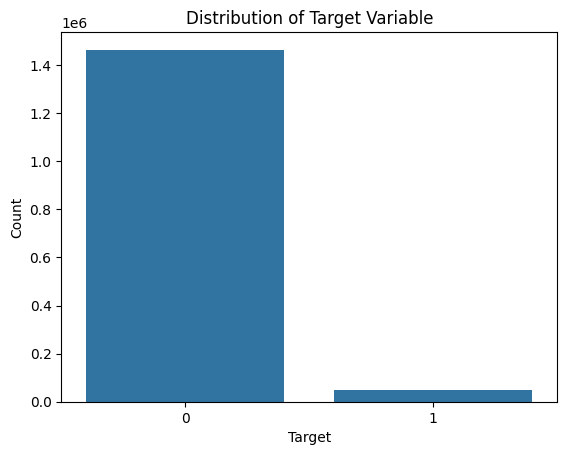

In [ ]:

target_counts = df_train['target'].value_counts()


sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
len(df_train1[df_train1['target'] == 0])

1478665

In [ ]:
len(df_train1[df_train1['target'] == 1])

47994

Next, we oversample and undersample at the same time, so that the target variable distribution is balanced

In [ ]:
# Calculate the number of rows with 'target' value 0 that will be removed (3/4 of total)
num_target_0_removed = int(len(df_train[df_train['target'] == 0]) * 3 / 4)
# Calculate the number of rows with 'target' value 1 that will be copied (7 times the original)
num_target_1_copied = len(df_train[df_train['target'] == 1]) * 7

df_target_1_copied = df_train[df_train['target'] == 1].copy()
for _ in range(6):
    df_train = pd.concat([df_train, df_target_1_copied], ignore_index=True)

df_train = df_train.drop(df_train[df_train['target'] == 0].sample(n=num_target_0_removed).index)

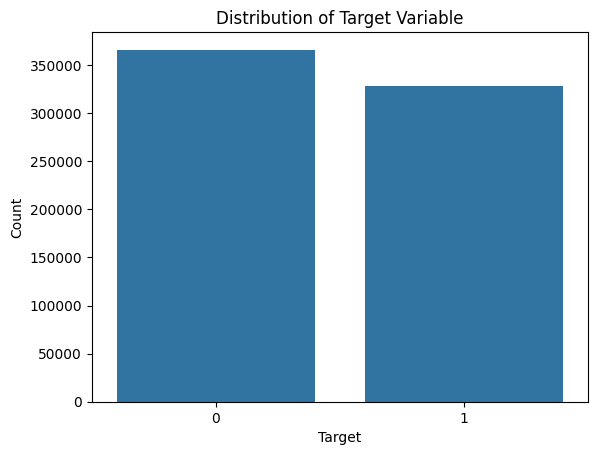

In [ ]:
target_counts = df_train['target'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Now, the target variable distribution is balanced

Then, we can use plot to see the trend between "WEEK_NUM" and "target".

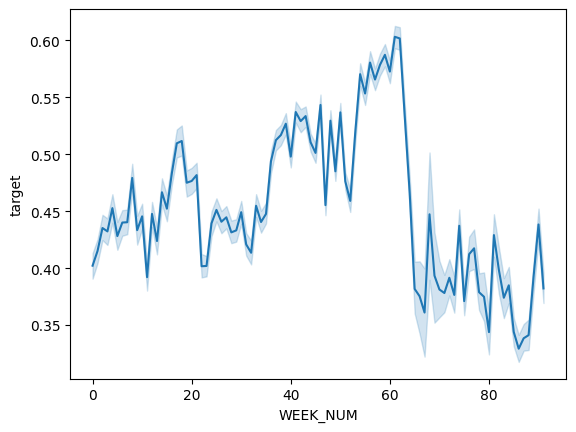

In [ ]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

Then, we can use the plot to the difference of target type distribution in different time dimensions.

Form the figure, we can see that the distrubution of the target object is balanced overall even though there exists some slight difference.

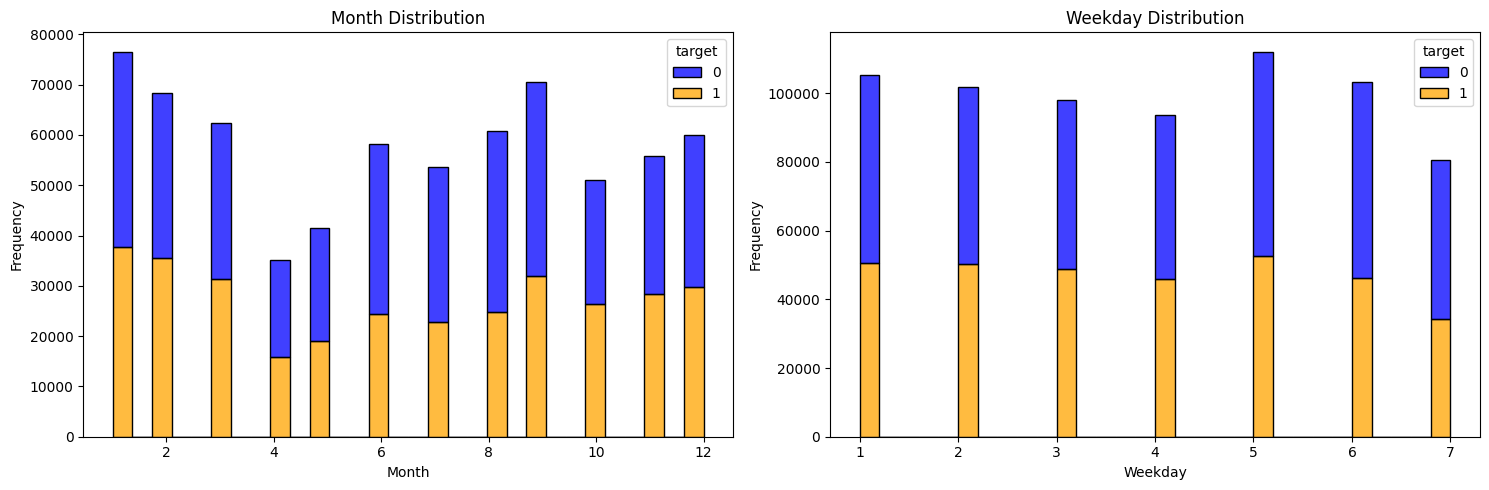

In [ ]:
plt.figure(figsize=(15, 5))
PALETTE = ['blue','orange']
plt.subplot(1, 2, 1)
# Plotting a stacked histogram for the 'month_decision' column, with specified parameters
sns.histplot(data=df_train, x='month_decision', bins=30, multiple="stack", kde=False, hue='target',
             palette=PALETTE)
plt.title('Month Distribution')
plt.xlabel('Month')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='weekday_decision', bins=30, multiple="stack", kde=False, hue='target',
             palette=PALETTE)
plt.title('Weekday Distribution')
plt.xlabel('Weekday')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

Then, we try to visualize the distribution of null value.

From the figure, we can see that some columns have more null values and some columns have less null values.

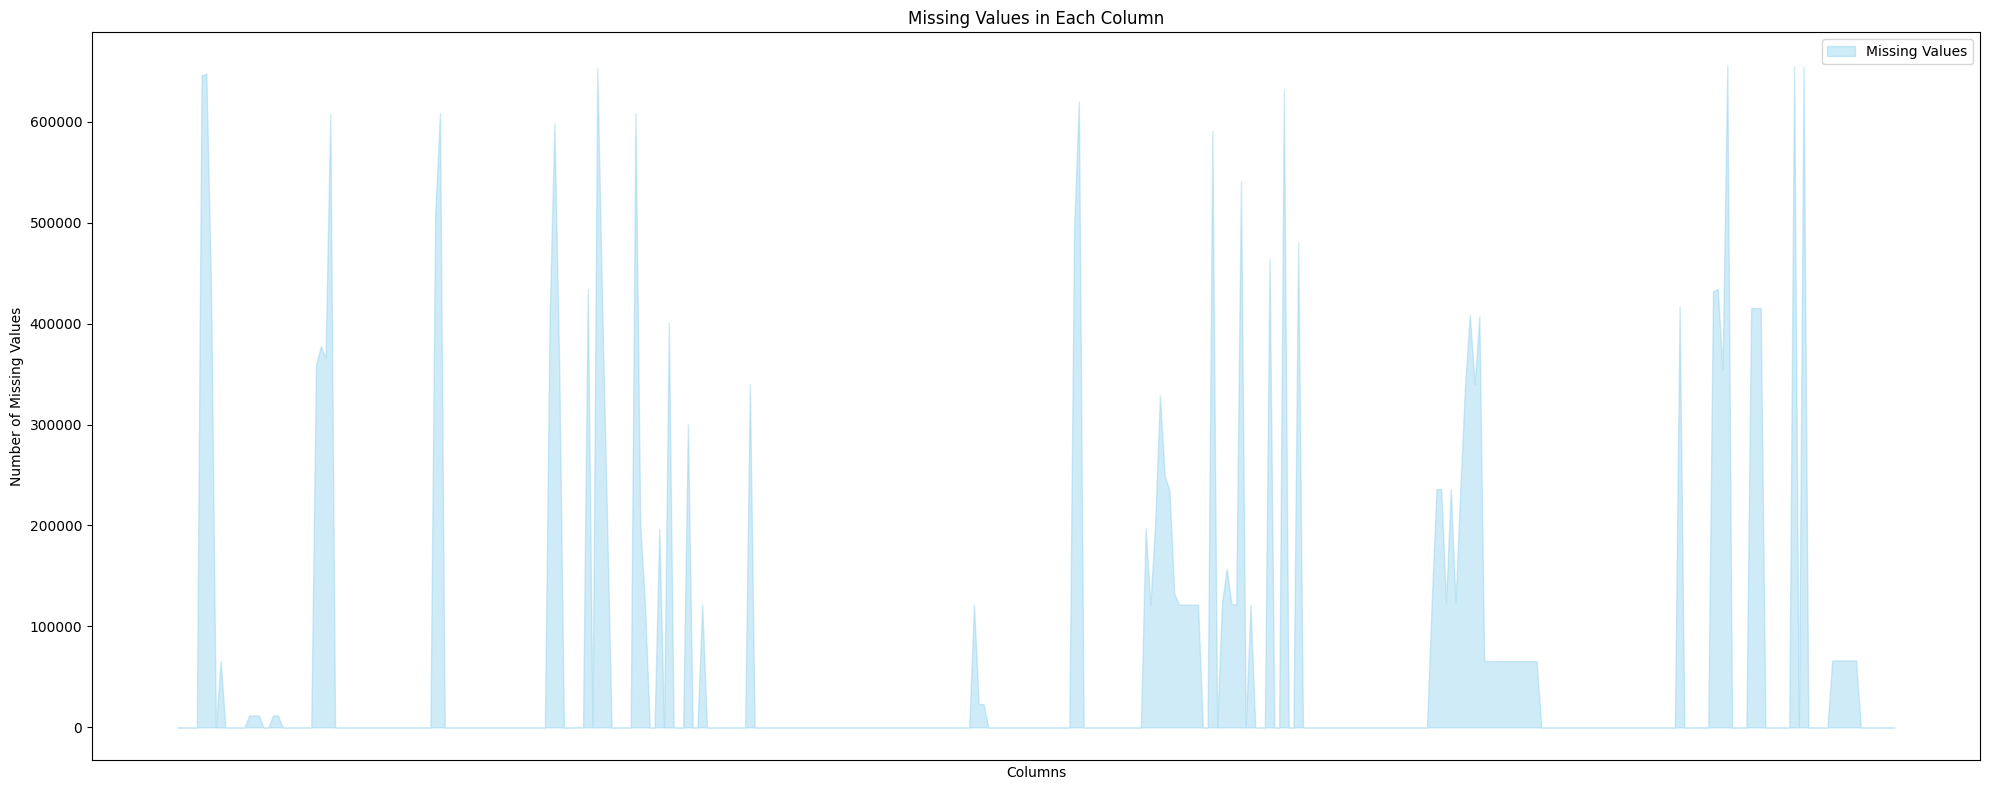

In [ ]:
# Calculating the number of missing values in each column of the training dataset
missing_values = df_train.isnull().sum()
missing_values = df_train.isnull().sum()

plt.figure(figsize=(20, 8))
# Filling the area between x-axis (column names) and y-axis (number of missing values)
plt.fill_between(missing_values.index, missing_values.values, color='skyblue', alpha=0.4, label='Missing Values')

plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')

plt.legend()

plt.xticks([])

plt.tight_layout()
plt.show()

Look at the correlation between the variables below.

We can see that there may exist some independent variables but we are not dealing with these variables right now. It is because we'll coduct feature selection later.

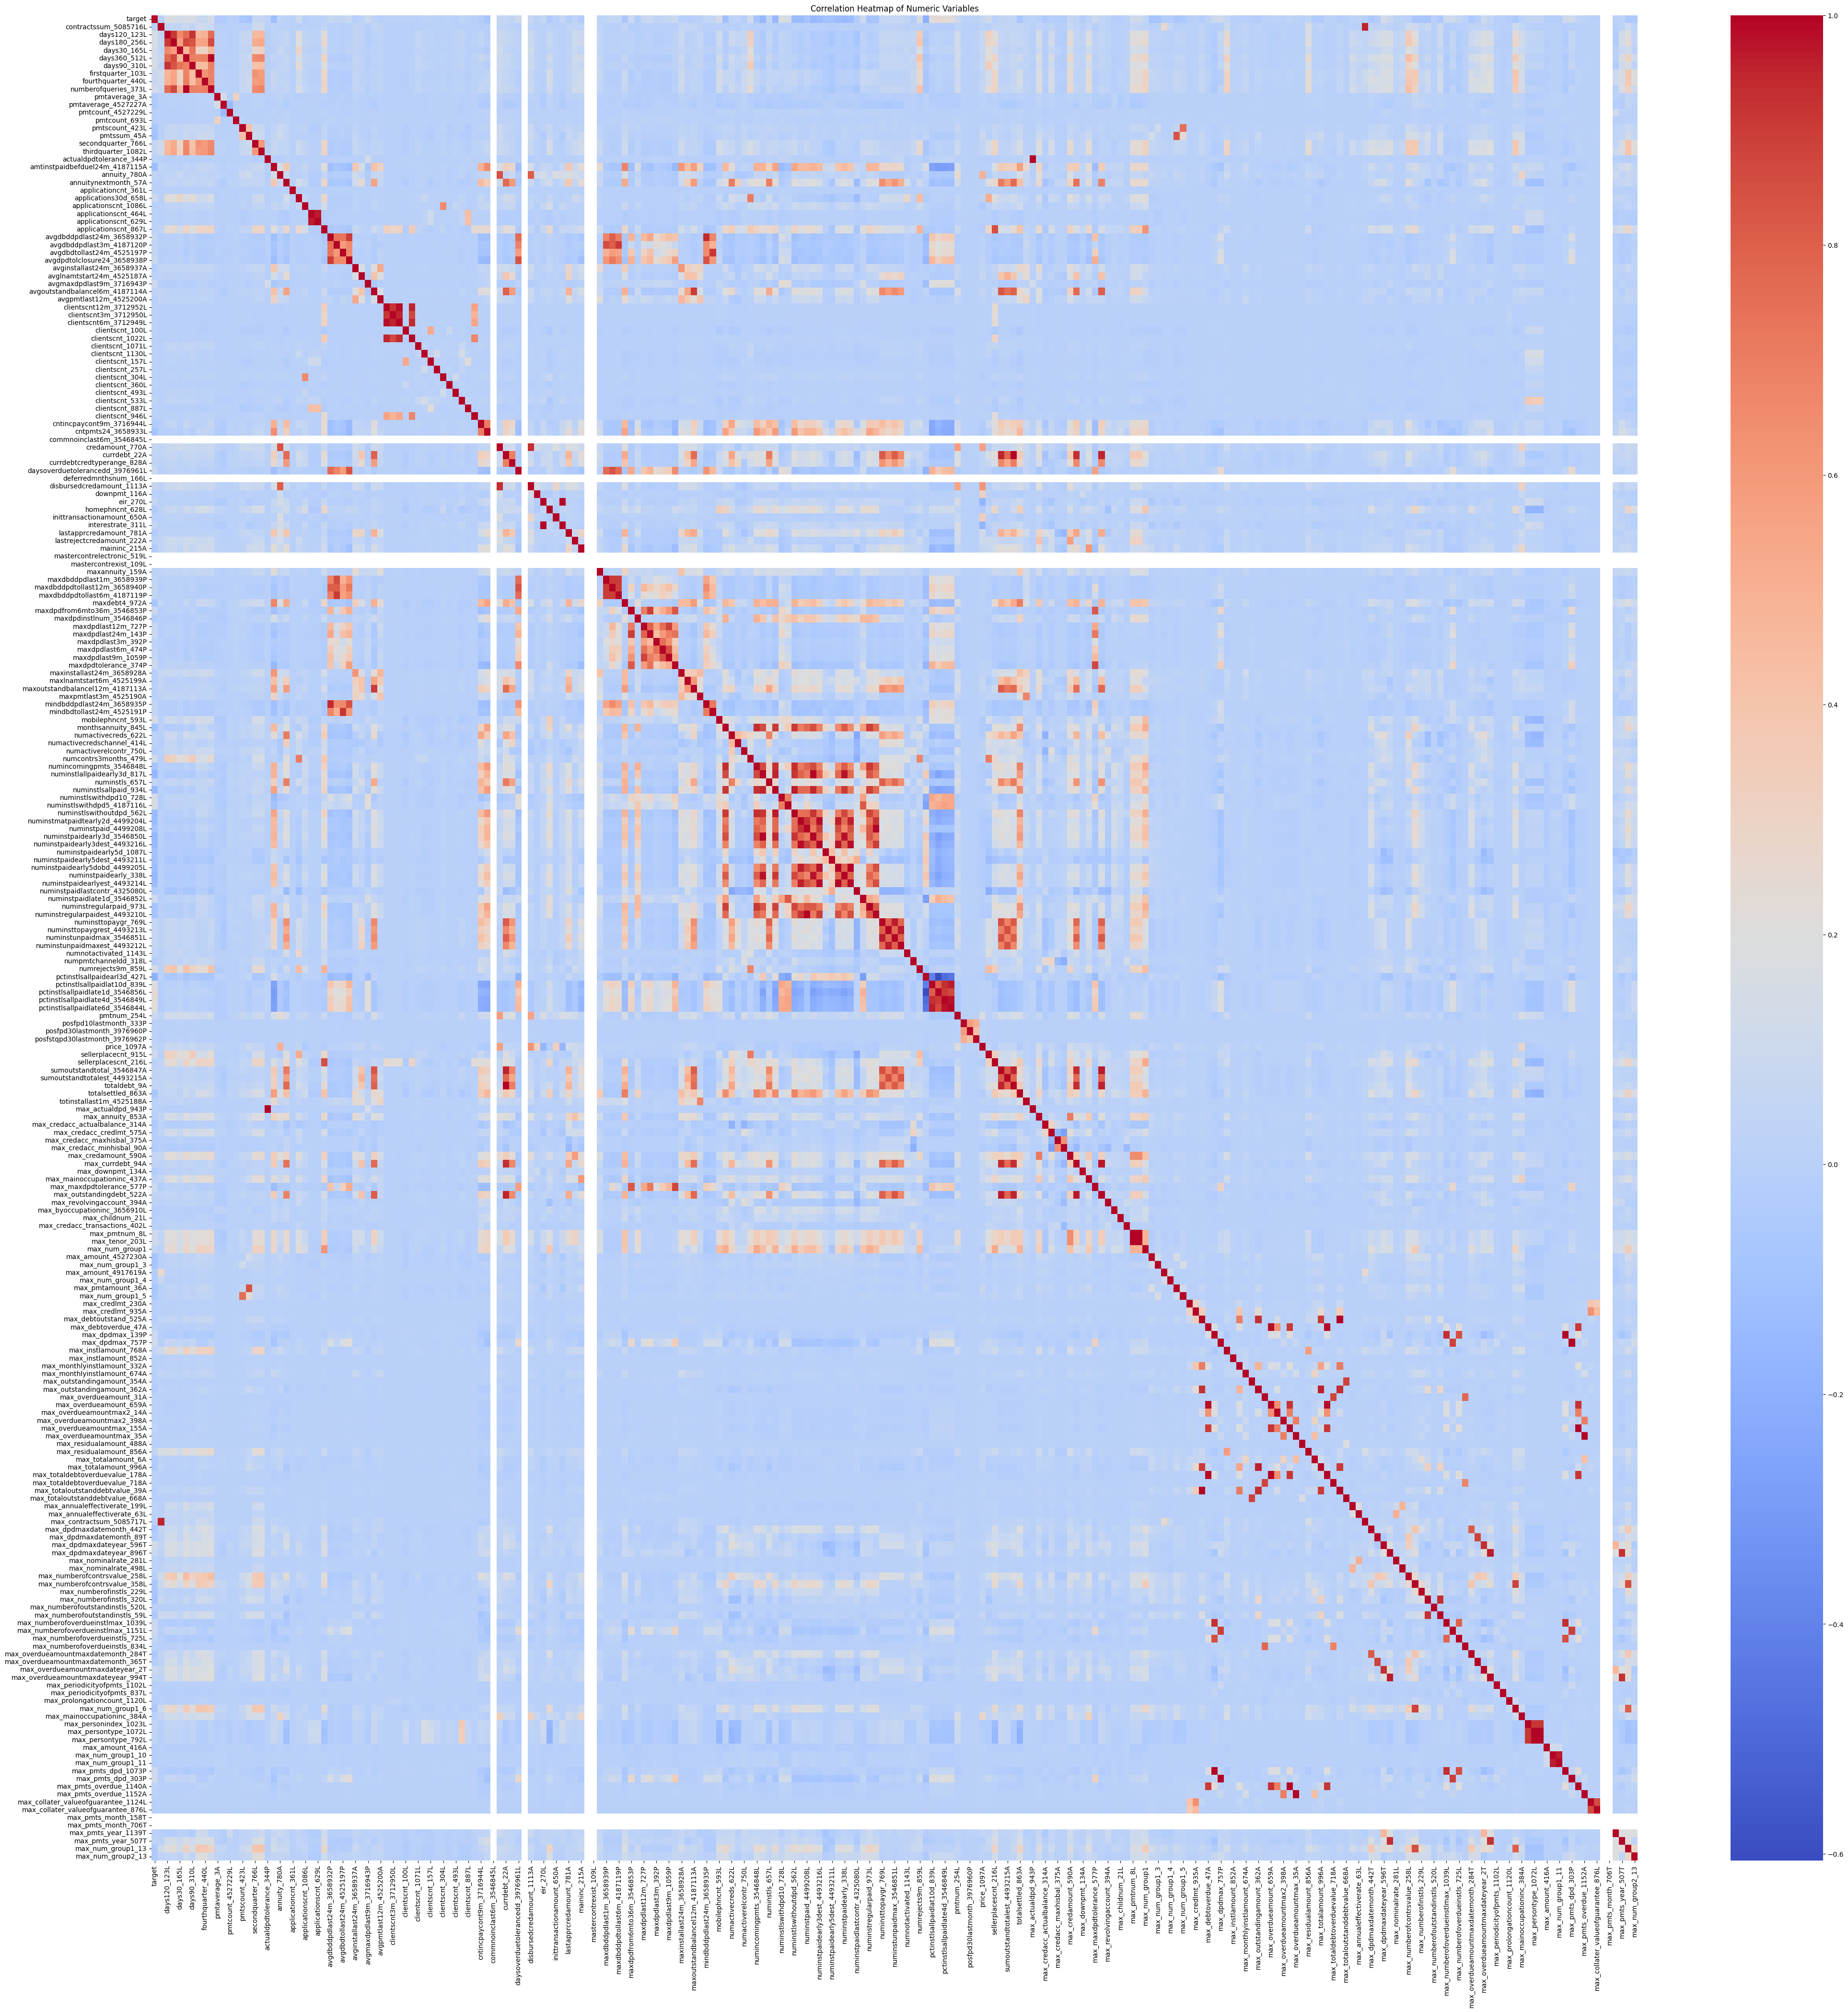

In [ ]:
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

df_numeric = df_train[numeric_columns]

# Calculating the correlation matrix between numeric columns
corr_matrix = df_numeric.corr()

plt.figure(figsize=(50, 50))
# Plotting the heatmap of correlations, annot=False means not displaying values in each cell, cmap specifies the color map, fmt=".2f" specifies the format of displayed values
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

### Feature Selection

In [ ]:
df_train.select_dtypes(exclude=['number']).columns

Index(['description_5085714M', 'education_1103M', 'education_88M',
       'maritalst_385M', 'maritalst_893M', 'requesttype_4525192L',
       'bankacctype_710L', 'cardtype_51L', 'credtype_322L',
       'disbursementtype_67L', 'equalitydataagreement_891L',
       'inittransactioncode_186L', 'isbidproduct_1095L', 'isdebitcard_729L',
       'lastapprcommoditycat_1041M', 'lastcancelreason_561M',
       'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M',
       'lastrejectreason_759M', 'lastrejectreasonclient_4145040M',
       'lastst_736L', 'opencred_647L', 'paytype1st_925L', 'paytype_783L',
       'twobodfilling_608L', 'typesuite_864L', 'max_cancelreason_3545846M',
       'max_education_1138M', 'max_postype_4733339M', 'max_rejectreason_755M',
       'max_rejectreasonclient_4145042M', 'max_credacc_status_367L',
       'max_credtype_587L', 'max_familystate_726L',
       'max_inittransactioncode_279L', 'max_isbidproduct_390L',
       'max_isdebitcard_527L', 'max_status_219L',
   

In [ ]:
def select_features_chi2(df, target_col, significance_level=0.05):
    selected_features = []

    for feature in df.columns:
        if feature == target_col:
            continue
        contingency_table = pd.crosstab(df[feature], df[target_col])
         # Calculate the chi-square statistic and p-value
        chi2, p, _, _ = chi2_contingency(contingency_table)
        # If the p-value is less than the significance level, add the feature to the selected features list
        if p < significance_level:
            selected_features.append(feature)

    return selected_features

def plot_feature_importance(importance, names, model_type, top_n=20):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False).head(top_n)
    plt.figure(figsize=(10, top_n*0.15))
    plt.barh(feature_importance['feature'], feature_importance['importance'], align='center', height=0.5)
    plt.title(f'{model_type} Feature Importance (Top {top_n})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()



def feature_selection_lgbm(X_train, y_train, num_iterations=100):
  # use LightGBM classifier model to do feature selection
    model = lgb.LGBMClassifier(n_estimators=num_iterations, random_state=42)
    feature_importance_values = np.zeros(X_train.shape[1])
    for _ in range(5):
        model.fit(X_train, y_train)
        feature_importance_values += model.feature_importances_ / 5
    plot_feature_importance(feature_importance_values, X_train.columns, 'LightGBM')
    selected_features = X_train.columns[np.where(feature_importance_values > 0)]
    return selected_features

def feature_selection_xgboost(X_train, y_train, num_iterations=100):
  # use XGBoost classifier model to do feature selection
    model = xgb.XGBClassifier(n_estimators=num_iterations, random_state=42, enable_categorical=True)
    feature_importance_values = np.zeros(X_train.shape[1])
    for _ in range(5):
        model.fit(X_train, y_train)
        feature_importance_values += model.feature_importances_ / 5
    plot_feature_importance(feature_importance_values, X_train.columns, 'XGBoost')
    selected_features = X_train.columns[np.where(feature_importance_values > 0)]
    return selected_features

def feature_selection_catboost(X_train, y_train, num_iterations=100):
  # use CatBoost classifier model to do feature selection
    cat_features = [col for col in X_train.columns if X_train[col].dtype.name == 'category']
    for col in cat_features:
      X_train[col] = X_train[col].astype(str).fillna('missing')
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    model = CatBoostClassifier(iterations=num_iterations, random_state=42, verbose=False)
    feature_importance_values = np.zeros(X_train.shape[1])
    for _ in range(5):
        model.fit(train_pool)
        feature_importance_values += model.feature_importances_ / 5
    plot_feature_importance(feature_importance_values, X_train.columns, 'CatBoost')
    selected_features = X_train.columns[np.where(feature_importance_values > 0)]
    return selected_features

In [ ]:
from scipy.stats import chi2_contingency
selected_features = select_features_chi2(df_train, 'target')

In [ ]:
df_train = df_train[list(set(selected_features+["case_id", "target","WEEK_NUM","month_decision","weekday_decision"]))]

The figure below shows the results of feature selection using LightGBM’s built-in feature importance.

[LightGBM] [Info] Number of positive: 328321, number of negative: 365939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.429602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44738
[LightGBM] [Info] Number of data points in the train set: 694260, number of used features: 342
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472908 -> initscore=-0.108475
[LightGBM] [Info] Start training from score -0.108475
[LightGBM] [Info] Number of positive: 328321, number of negative: 365939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.584969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44738
[LightGBM] [Info] Number of data points in the train set: 694260, number of used features: 342
[LightGB

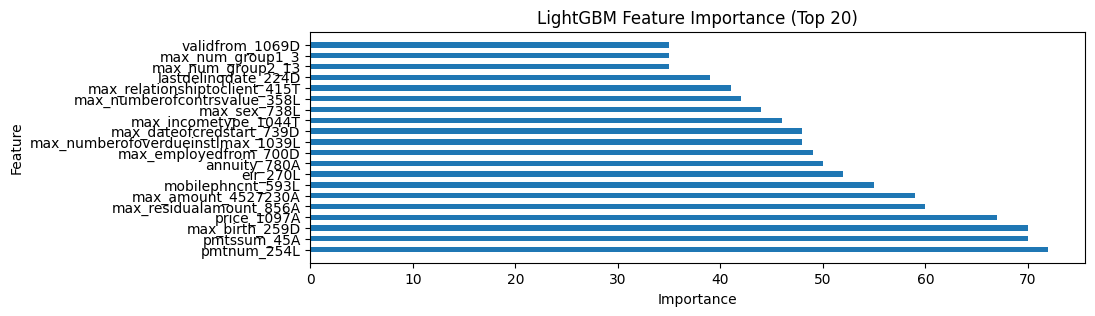

Selected Features: Index(['numrejects9m_859L', 'max_overdueamountmax_155A', 'numinsttopaygr_769L',
       'max_totalamount_996A', 'days120_123L', 'avgdbddpdlast3m_4187120P',
       'maxannuity_159A', 'max_numberofinstls_320L', 'totalsettled_863A',
       'max_numberofoutstandinstls_59L',
       ...
       'max_overdueamount_659A', 'clientscnt12m_3712952L',
       'clientscnt3m_3712950L', 'max_debtoutstand_525A',
       'max_overdueamountmax2date_1002D', 'maxdpdlast12m_727P',
       'numinstpaidearly_338L', 'dateofbirth_337D', 'max_residualamount_856A',
       'applicationscnt_867L'],
      dtype='object', length=244)


In [ ]:
optimized_features = feature_selection_lgbm(df_train.drop(columns=["case_id", "target","WEEK_NUM"]), df_train["target"])
print("Selected Features:", optimized_features)

In [ ]:
df_train_LGBM=df_train[list(set(list(optimized_features)+["case_id", "target","WEEK_NUM","month_decision","weekday_decision"]))]

The figure below shows the results of feature selection using XGBoost’s built-in feature importance.

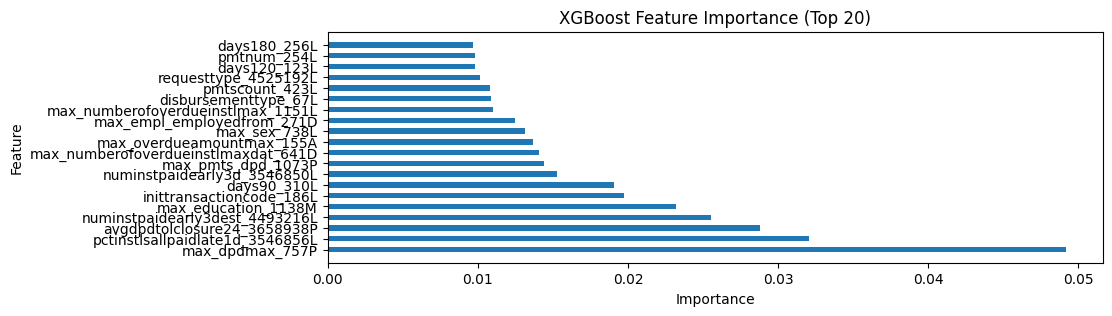

Selected Features: Index(['numrejects9m_859L', 'max_overdueamountmax_155A', 'firstquarter_103L',
       'numinsttopaygr_769L', 'maritalst_893M', 'max_totalamount_996A',
       'days120_123L', 'avgdbddpdlast3m_4187120P', 'maxannuity_159A',
       'max_numberofinstls_320L',
       ...
       'clientscnt12m_3712952L', 'clientscnt3m_3712950L',
       'max_debtoutstand_525A', 'max_overdueamountmax2date_1002D',
       'maxdpdlast12m_727P', 'max_isbidproduct_390L', 'numinstpaidearly_338L',
       'dateofbirth_337D', 'max_residualamount_856A', 'applicationscnt_867L'],
      dtype='object', length=314)


In [ ]:
optimized_features = feature_selection_xgboost(df_train.drop(columns=["case_id", "target","WEEK_NUM"]), df_train["target"])
print("Selected Features:", optimized_features)

In [ ]:
df_train_XGB=df_train[list(set(list(optimized_features)+["case_id", "target","WEEK_NUM","month_decision","weekday_decision"]))]

The figure below shows the results of feature selection using CatBoost’s built-in feature importance.

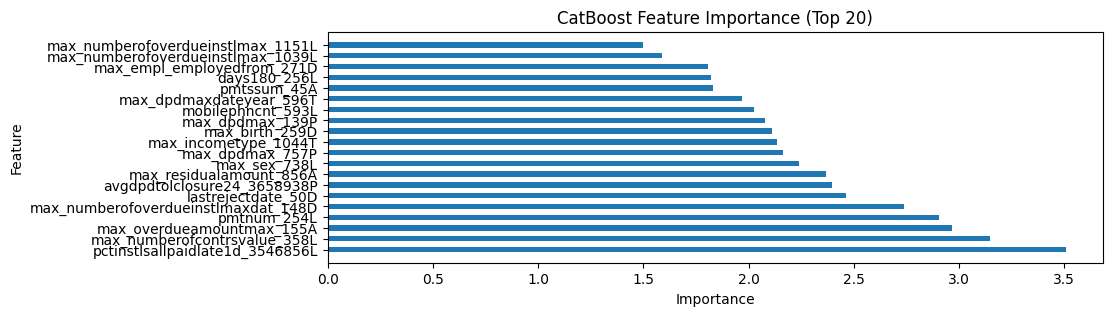

Selected Features: Index(['numrejects9m_859L', 'max_overdueamountmax_155A', 'numinsttopaygr_769L',
       'max_totalamount_996A', 'days120_123L', 'avgdbddpdlast3m_4187120P',
       'maxannuity_159A', 'max_numberofinstls_320L', 'totalsettled_863A',
       'max_numberofoutstandinstls_59L',
       ...
       'homephncnt_628L', 'firstclxcampaign_1125D', 'clientscnt12m_3712952L',
       'clientscnt3m_3712950L', 'max_debtoutstand_525A',
       'max_overdueamountmax2date_1002D', 'numinstpaidearly_338L',
       'dateofbirth_337D', 'max_residualamount_856A', 'applicationscnt_867L'],
      dtype='object', length=212)


In [ ]:
optimized_features = feature_selection_catboost(df_train.drop(columns=["case_id", "target","WEEK_NUM"]), df_train["target"])
print("Selected Features:", optimized_features)

In [ ]:
df_train_CatB=df_train[list(set(list(optimized_features)+["case_id", "target","WEEK_NUM","month_decision","weekday_decision"]))]

### Training

LightGBM Model

In [ ]:
# Preparing the feature matrix and the target vector from the training dataset
X = df_train_LGBM.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train_LGBM["target"]
weeks = df_train_LGBM["WEEK_NUM"]# This holds the group variable for stratified sampling

# Initializing the StratifiedGroupKFold to ensure training data is split in a stratified fashion
# that respects group boundaries
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# LightGBM model parameters
params = {
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "objective": "binary",    # Binary classification
    "metric": "auc",          # Evaluation metric: Area Under the Curve
    "max_depth": 8,           # Maximum depth of the trees
    "learning_rate": 0.05,    # Step size shrinkage used to prevent overfitting
    "n_estimators": 1000,     # Number of boosted trees to fit
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "colsample_bynode": 0.8,  # Subsample ratio of columns for each split
    "verbose": -1,            # LightGBM verbosity
    "random_state": 42,       # Controls both the randomness of the bootstrapping and features sampling
    "device": "cpu"    # Specifies the platform (CPU or GPU) that LightGBM will run on

}

fitted_models = []  # To store the trained models for each fold

# Cross-validation procedure to generate and evaluate multiple models based on different data subsets
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Initialize and train the LightGBM model with the specified parameters
    model_lgb = lgb.LGBMClassifier(**params)
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)] # Evaluation and early stopping
    )

    fitted_models.append(model_lgb)# Append the trained model to the list

#Using a VotingModel ensemble method to combine the predictions from all trained models
model_LGB = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.832692
[200]	valid_0's auc: 0.843351
[300]	valid_0's auc: 0.847256
[400]	valid_0's auc: 0.848988
[500]	valid_0's auc: 0.849448
[600]	valid_0's auc: 0.849813
[700]	valid_0's auc: 0.849951
[800]	valid_0's auc: 0.850063
[900]	valid_0's auc: 0.850155
Early stopping, best iteration is:
[898]	valid_0's auc: 0.850157
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.838532
[200]	valid_0's auc: 0.849581
[300]	valid_0's auc: 0.853185
[400]	valid_0's auc: 0.854768
[500]	valid_0's auc: 0.855364
[600]	valid_0's auc: 0.855663
[700]	valid_0's auc: 0.855862
[800]	valid_0's auc: 0.855853
[900]	valid_0's auc: 0.855833
Early stopping, best iteration is:
[845]	valid_0's auc: 0.855959
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.834333
[200]	valid_0's auc: 0.845036
[300]	valid_0's auc: 0.848829
[400]	valid_0's auc: 0.85063
[500]	valid_0's auc: 0.85

### Prediction

In [ ]:
df_test.columns

Index(['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision',
       'assignmentdate_238D', 'assignmentdate_4527235D', 'birthdate_574D',
       'contractssum_5085716L', 'dateofbirth_337D',
       ...
       'max_subjectroles_name_541M', 'max_subjectroles_name_838M',
       'max_collater_valueofguarantee_1124L',
       'max_collater_valueofguarantee_876L', 'max_pmts_month_158T',
       'max_pmts_month_706T', 'max_pmts_year_1139T', 'max_pmts_year_507T',
       'max_num_group1_13', 'max_num_group2_13'],
      dtype='object', length=361)

In [ ]:
#LightGBM prediction
# Preparing the test feature matrix, ensuring it matches the columns used during training, excluding 'WEEK_NUM'
X_test_lgb = df_test[list(df_train_LGBM.drop(columns=["target"]).columns)].drop(columns=["WEEK_NUM"])
X_test_lgb = X_test_lgb.set_index("case_id")

# Generate predictions using the ensemble model, selecting only the probabilities for the positive class
y_pred_lgb = pd.Series(model_LGB.predict_proba(X_test_lgb)[:, 1], index=X_test_lgb.index)
# Display the first few predictions to verify the output
print(y_pred_lgb.head())

case_id
1911587    0.028370
1679928    0.098218
149421     0.181099
992962     0.049547
1812637    0.293403
dtype: float64


In [ ]:
# Calculate the accuracy of the model on the test data by comparing the actual target values to the predicted values
accuracy = accuracy_score(df_test['target'], model_LGB.predict(X_test_lgb)>0.5)
# Print the out-of-sample accuracy to evaluate model performance on unseen data
print("Out of Sample Accuracy:", accuracy)

Out of Sample Accuracy: 0.7959659943323887


### Result


In [ ]:
# Create a DataFrame from the prediction probabilities and save it as a CSV file
pd.DataFrame(y_pred_lgb,columns=['score']).to_csv('lgb_result.csv')

# Training with 2 more different Models

###XGBoost Model

In [ ]:
# Preparing feature matrix and target vector, excluding unnecessary columns
X = df_train_XGB.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train_XGB["target"]
weeks = df_train_XGB["WEEK_NUM"]# Groups for stratified sampling

# Initializing StratifiedGroupKFold for cross-validation with 5 folds, no shuffling
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Parameters for the XGBoost classifier, configured for binary classification
params = {
"objective": "binary:logistic",    # Binary logistic regression for binary classification
    "eval_metric": "auc",              # Evaluation metric is Area Under the Curve
    "max_depth": 6,                    # Maximum tree depth
    "learning_rate": 0.05,             # Learning rate for updates
    "n_estimators": 1000,              # Number of trees
    "colsample_bytree": 0.8,           # Subsample ratio of columns when constructing each tree
    "colsample_bynode": 0.8,           # Subsample ratio of columns for each split
    "verbosity": 0,                    # Verbosity of printing messages
    "random_state": 42,                # Random number seed
    "tree_method": "gpu_hist",         # Use GPU acceleration for histogram computation
    "enable_categorical": True         # Enable support for categorical features
}

fitted_models = []# To store models from each fold

# Cross-validation loop to fit models on each fold
for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y, groups=weeks)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Initialize and train the XGBoost classifier with specified parameters
    model_xg = xgb.XGBClassifier(**params)
    model_xg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100 # Controls the verbosity of the output during training
    )

    fitted_models.append(model_xg) # Append the trained model to the list
    print(f"Completed training fold {fold+1}/{cv.n_splits}") # Print completion of each fold

# Function to compute average predictions from multiple models
def average_predict(models, X):
    preds = [model_xg.predict_proba(X)[:, 1] for model_xg in models]# Predict probabilities for the positive class
    return np.mean(preds, axis=0) # Average predictions across all models

# Optionally, create a voting classifier for ensemble learning
model_XG = VotingClassifier(estimators=[(f"model_{i}", m) for i, m in enumerate(fitted_models)], voting='soft')




[0]	validation_0-auc:0.73811
[100]	validation_0-auc:0.83381
[200]	validation_0-auc:0.84337
[300]	validation_0-auc:0.84645
[400]	validation_0-auc:0.84794
[500]	validation_0-auc:0.84868
[600]	validation_0-auc:0.84904
[700]	validation_0-auc:0.84925
[800]	validation_0-auc:0.84909
[900]	validation_0-auc:0.84893
[999]	validation_0-auc:0.84867
Completed training fold 1/5
[0]	validation_0-auc:0.74556
[100]	validation_0-auc:0.83924
[200]	validation_0-auc:0.84847
[300]	validation_0-auc:0.85167
[400]	validation_0-auc:0.85292
[500]	validation_0-auc:0.85363
[600]	validation_0-auc:0.85391
[700]	validation_0-auc:0.85392
[800]	validation_0-auc:0.85407
[900]	validation_0-auc:0.85403
[999]	validation_0-auc:0.85390
Completed training fold 2/5
[0]	validation_0-auc:0.73999
[100]	validation_0-auc:0.83619
[200]	validation_0-auc:0.84513
[300]	validation_0-auc:0.84842
[400]	validation_0-auc:0.85011
[500]	validation_0-auc:0.85091
[600]	validation_0-auc:0.85140
[700]	validation_0-auc:0.85156
[800]	validation_0-a

XGBoost Prediection and Results

In [ ]:
# Preparing X_test
X_test_xg = df_test[list(df_train_XGB.drop(columns=["target"]).columns)].drop(columns=["WEEK_NUM"])
X_test_xg = X_test_xg.set_index("case_id")

# Collecting predictions from each model
model_predictions = [model_xg.predict_proba(X_test_xg)[:, 1] for model_xg in fitted_models]

# Calculating the average of the probabilities across all models
average_probabilities = np.mean(model_predictions, axis=0)

# Creating a pandas Series to store the final averaged probabilities
y_pred_xg = pd.Series(average_probabilities, index=X_test_xg.index)

print(y_pred_xg.head())


case_id
1911587    0.020822
1679928    0.105364
149421     0.135711
992962     0.047066
1812637    0.249646
dtype: float32


In [ ]:
# Calculate the accuracy of the ensemble model by comparing the actual test targets with the predicted probabilities
accuracy = accuracy_score(df_test['target'], average_probabilities>0.5)
# Print the out-of-sample accuracy to evaluate model performance on unseen data
print("Out of Sample Accuracy:", accuracy)

Out of Sample Accuracy: 0.8196366061010169


In [ ]:
# Create a DataFrame from the prediction probabilities and save it as a CSV file
y_pred_xg.to_csv('XGB_result.csv')

###CatBoost Model

In [ ]:
# Preparing feature matrix and target vector by removing non-predictive columns
X = df_train_CatB.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train_CatB["target"]
groups = df_train_CatB["WEEK_NUM"]

# Identifying categorical columns in the dataset
cat_features = [col for col in X.columns if X[col].dtype.name == 'category']

# Fill NaN values in categorical columns with a specific category 'missing'
for col in cat_features:
    X[col] = X[col].astype(str).fillna('missing')

# CatBoost parameters
params = {
 "iterations": 1000,                    # Number of training iterations
    "learning_rate": 0.05,                 # Step size for weight updates
    "depth": 6,                            # Depth of each tree
    "loss_function": 'Logloss',            # Loss function for binary classification
    "eval_metric": 'AUC',                  # Performance metric
    "random_seed": 42,                     # Seed for randomness, allows reproducibility
    "verbose": 100,                        # Frequency of logs during training
    "task_type": "GPU",                    # Utilize GPU for training
    "early_stopping_rounds": 50,           # Stop training if no improvement after 50 rounds
    "border_count": 128                    # Number of splits for numerical features
}

# Model training setup
fitted_models = []
cv = GroupKFold(n_splits=5)# Group-wise cross-validation setup


# Training loop to fit a CatBoost model on each fold
for idx_train, idx_valid in cv.split(X, y, groups=groups):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Use Pool to manage data and specify categorical features
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    # Initialize and train CatBoost Classifier with the specified parameters
    model_cat = CatBoostClassifier(**params)
    model_cat.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True# Use the best model encountered during training
    )

    fitted_models.append(model_cat)

# Combining models (simple averaging method for demonstration)
def average_predict(models, X):
    preds_cat = [model_cat.predict_proba(X)[:, 1] for model_cat in models]# Predict probabilities for the positive class
    return np.mean(preds_cat, axis=0)# Compute the mean of predictions across all models


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7205750	best: 0.7205750 (0)	total: 80ms	remaining: 1m 19s
100:	test: 0.8282313	best: 0.8282313 (100)	total: 6.64s	remaining: 59.1s
200:	test: 0.8391217	best: 0.8391217 (200)	total: 13.2s	remaining: 52.3s
300:	test: 0.8439427	best: 0.8439427 (300)	total: 19.7s	remaining: 45.8s
400:	test: 0.8468937	best: 0.8469211 (399)	total: 26.3s	remaining: 39.2s
500:	test: 0.8486888	best: 0.8486888 (500)	total: 32.8s	remaining: 32.7s
600:	test: 0.8498485	best: 0.8498769 (597)	total: 39.4s	remaining: 26.1s
700:	test: 0.8509452	best: 0.8509527 (682)	total: 46s	remaining: 19.6s
800:	test: 0.8513423	best: 0.8513423 (800)	total: 52.5s	remaining: 13s
900:	test: 0.8517945	best: 0.8518022 (886)	total: 59s	remaining: 6.49s
999:	test: 0.8519803	best: 0.8520235 (984)	total: 1m 5s	remaining: 0us
bestTest = 0.8520234823
bestIteration = 984
Shrink model to first 985 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7242052	best: 0.7242052 (0)	total: 71.5ms	remaining: 1m 11s
100:	test: 0.8310981	best: 0.8310981 (100)	total: 6.71s	remaining: 59.8s
200:	test: 0.8420066	best: 0.8420066 (200)	total: 13.3s	remaining: 52.8s
300:	test: 0.8469799	best: 0.8469799 (300)	total: 19.8s	remaining: 46s
400:	test: 0.8501597	best: 0.8501597 (400)	total: 26.3s	remaining: 39.3s
500:	test: 0.8521035	best: 0.8521035 (500)	total: 32.8s	remaining: 32.7s
600:	test: 0.8532677	best: 0.8532704 (599)	total: 39.3s	remaining: 26.1s
700:	test: 0.8542501	best: 0.8542501 (700)	total: 45.8s	remaining: 19.5s
800:	test: 0.8548877	best: 0.8548877 (800)	total: 52.3s	remaining: 13s
900:	test: 0.8553242	best: 0.8554293 (892)	total: 58.8s	remaining: 6.46s
bestTest = 0.8554292917
bestIteration = 892
Shrink model to first 893 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269124	best: 0.7269124 (0)	total: 71.5ms	remaining: 1m 11s
100:	test: 0.8278049	best: 0.8278049 (100)	total: 6.7s	remaining: 59.6s
200:	test: 0.8390949	best: 0.8390949 (200)	total: 13.3s	remaining: 52.9s
300:	test: 0.8441121	best: 0.8441121 (300)	total: 19.8s	remaining: 46.1s
400:	test: 0.8470452	best: 0.8470452 (400)	total: 26.3s	remaining: 39.3s
500:	test: 0.8485749	best: 0.8486022 (495)	total: 32.8s	remaining: 32.7s
600:	test: 0.8500222	best: 0.8500222 (600)	total: 39.4s	remaining: 26.2s
700:	test: 0.8509687	best: 0.8509758 (696)	total: 46s	remaining: 19.6s
800:	test: 0.8513361	best: 0.8514207 (789)	total: 52.5s	remaining: 13s
bestTest = 0.8514207006
bestIteration = 789
Shrink model to first 790 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7271537	best: 0.7271537 (0)	total: 73.5ms	remaining: 1m 13s
100:	test: 0.8266033	best: 0.8266033 (100)	total: 6.76s	remaining: 1m
200:	test: 0.8366637	best: 0.8366637 (200)	total: 13.3s	remaining: 53s
300:	test: 0.8417891	best: 0.8417891 (300)	total: 19.9s	remaining: 46.2s
400:	test: 0.8445852	best: 0.8445852 (400)	total: 26.4s	remaining: 39.4s
500:	test: 0.8464515	best: 0.8464515 (500)	total: 32.9s	remaining: 32.8s
600:	test: 0.8479028	best: 0.8479028 (600)	total: 39.4s	remaining: 26.2s
700:	test: 0.8485841	best: 0.8486638 (696)	total: 45.8s	remaining: 19.5s
bestTest = 0.8487735987
bestIteration = 745
Shrink model to first 746 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7238580	best: 0.7238580 (0)	total: 72.4ms	remaining: 1m 12s
100:	test: 0.8297901	best: 0.8297901 (100)	total: 6.7s	remaining: 59.6s
200:	test: 0.8402348	best: 0.8402348 (200)	total: 13.3s	remaining: 52.8s
300:	test: 0.8457661	best: 0.8457661 (300)	total: 19.9s	remaining: 46.1s
400:	test: 0.8487443	best: 0.8487499 (398)	total: 26.4s	remaining: 39.5s
500:	test: 0.8509343	best: 0.8509343 (500)	total: 33s	remaining: 32.9s
600:	test: 0.8522608	best: 0.8522778 (599)	total: 39.5s	remaining: 26.2s
700:	test: 0.8531803	best: 0.8531803 (700)	total: 45.9s	remaining: 19.6s
800:	test: 0.8537449	best: 0.8537516 (799)	total: 52.4s	remaining: 13s
900:	test: 0.8543310	best: 0.8543333 (899)	total: 58.9s	remaining: 6.47s
999:	test: 0.8547843	best: 0.8547843 (999)	total: 1m 5s	remaining: 0us
bestTest = 0.8547842503
bestIteration = 999


CatBoost Prediction and results

In [ ]:
# Ensure the test dataset structure matches the training dataset, excluding non-predictive columns
X_test_CatB=df_test[list(df_train_CatB.drop(columns=["target"]).columns)].set_index('case_id')
# Convert categorical columns to string type and fill NaN values with 'missing' to maintain data integrity
X_test_CatB[cat_features] = X_test_CatB[cat_features].astype(str).fillna('missing')

# Create a Pool object for the test data, specifying the categorical features for CatBoost processing
test_pool = Pool(X_test_CatB, cat_features=cat_features)

# Predict probabilities for the positive class using the fitted CatBoost model on the prepared test data
y_pred_cat = pd.Series(model_cat.predict_proba(test_pool)[:, 1], index=X_test_CatB.index)
# Output the first few predictions to check and verify the output
print(y_pred_cat.head())



case_id
1911587    0.052600
1679928    0.165412
149421     0.270684
992962     0.082798
1812637    0.260636
dtype: float64


In [ ]:
# Calculate the accuracy of the ensemble model by comparing the actual test targets with the predicted probabilities
accuracy = accuracy_score(df_test['target'], y_pred_cat>0.5)
# Print the out-of-sample accuracy to evaluate model performance on unseen data
print("Out of Sample Accuracy:", accuracy)

Out of Sample Accuracy: 0.7901316886147691


In [ ]:
# Create a DataFrame from the prediction probabilities and save it as a CSV file
y_pred_cat.to_csv("CatBoost_result.csv")